In [1]:
import tensorflow as tf

print("Versión de TensorFlow:", tf.__version__)


Versión de TensorFlow: 2.13.0


In [2]:
import keras

print("Versión de Keras:", keras.__version__)


Versión de Keras: 2.13.1


In [80]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import os
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Model
import pickle
import math
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

In [67]:
train_data_generator = ImageDataGenerator(
    rescale = 1.0/255.0,  # Normalización simple
    # Data augmentation
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.4,
    horizontal_flip = True
)

test_data_generator = ImageDataGenerator(
    rescale = 1.0/255.0  # Normalización simple
)


## Here the effect of resizing are considered. 2 attempts 1 with 100x100 and one with 224x224

In [68]:
batch_size = 128


train_generator = train_data_generator.flow_from_directory(directory="../Train_original",
                                                           class_mode ="sparse",
                                                          target_size = (224 , 224),
                                                          batch_size = batch_size)

test_generator = test_data_generator.flow_from_directory(directory="../Test_original",
                                                         class_mode ="sparse",
                                                        target_size = (224 , 224),
                                                        batch_size = batch_size)

Found 4426 images belonging to 12 classes.
Found 1113 images belonging to 12 classes.


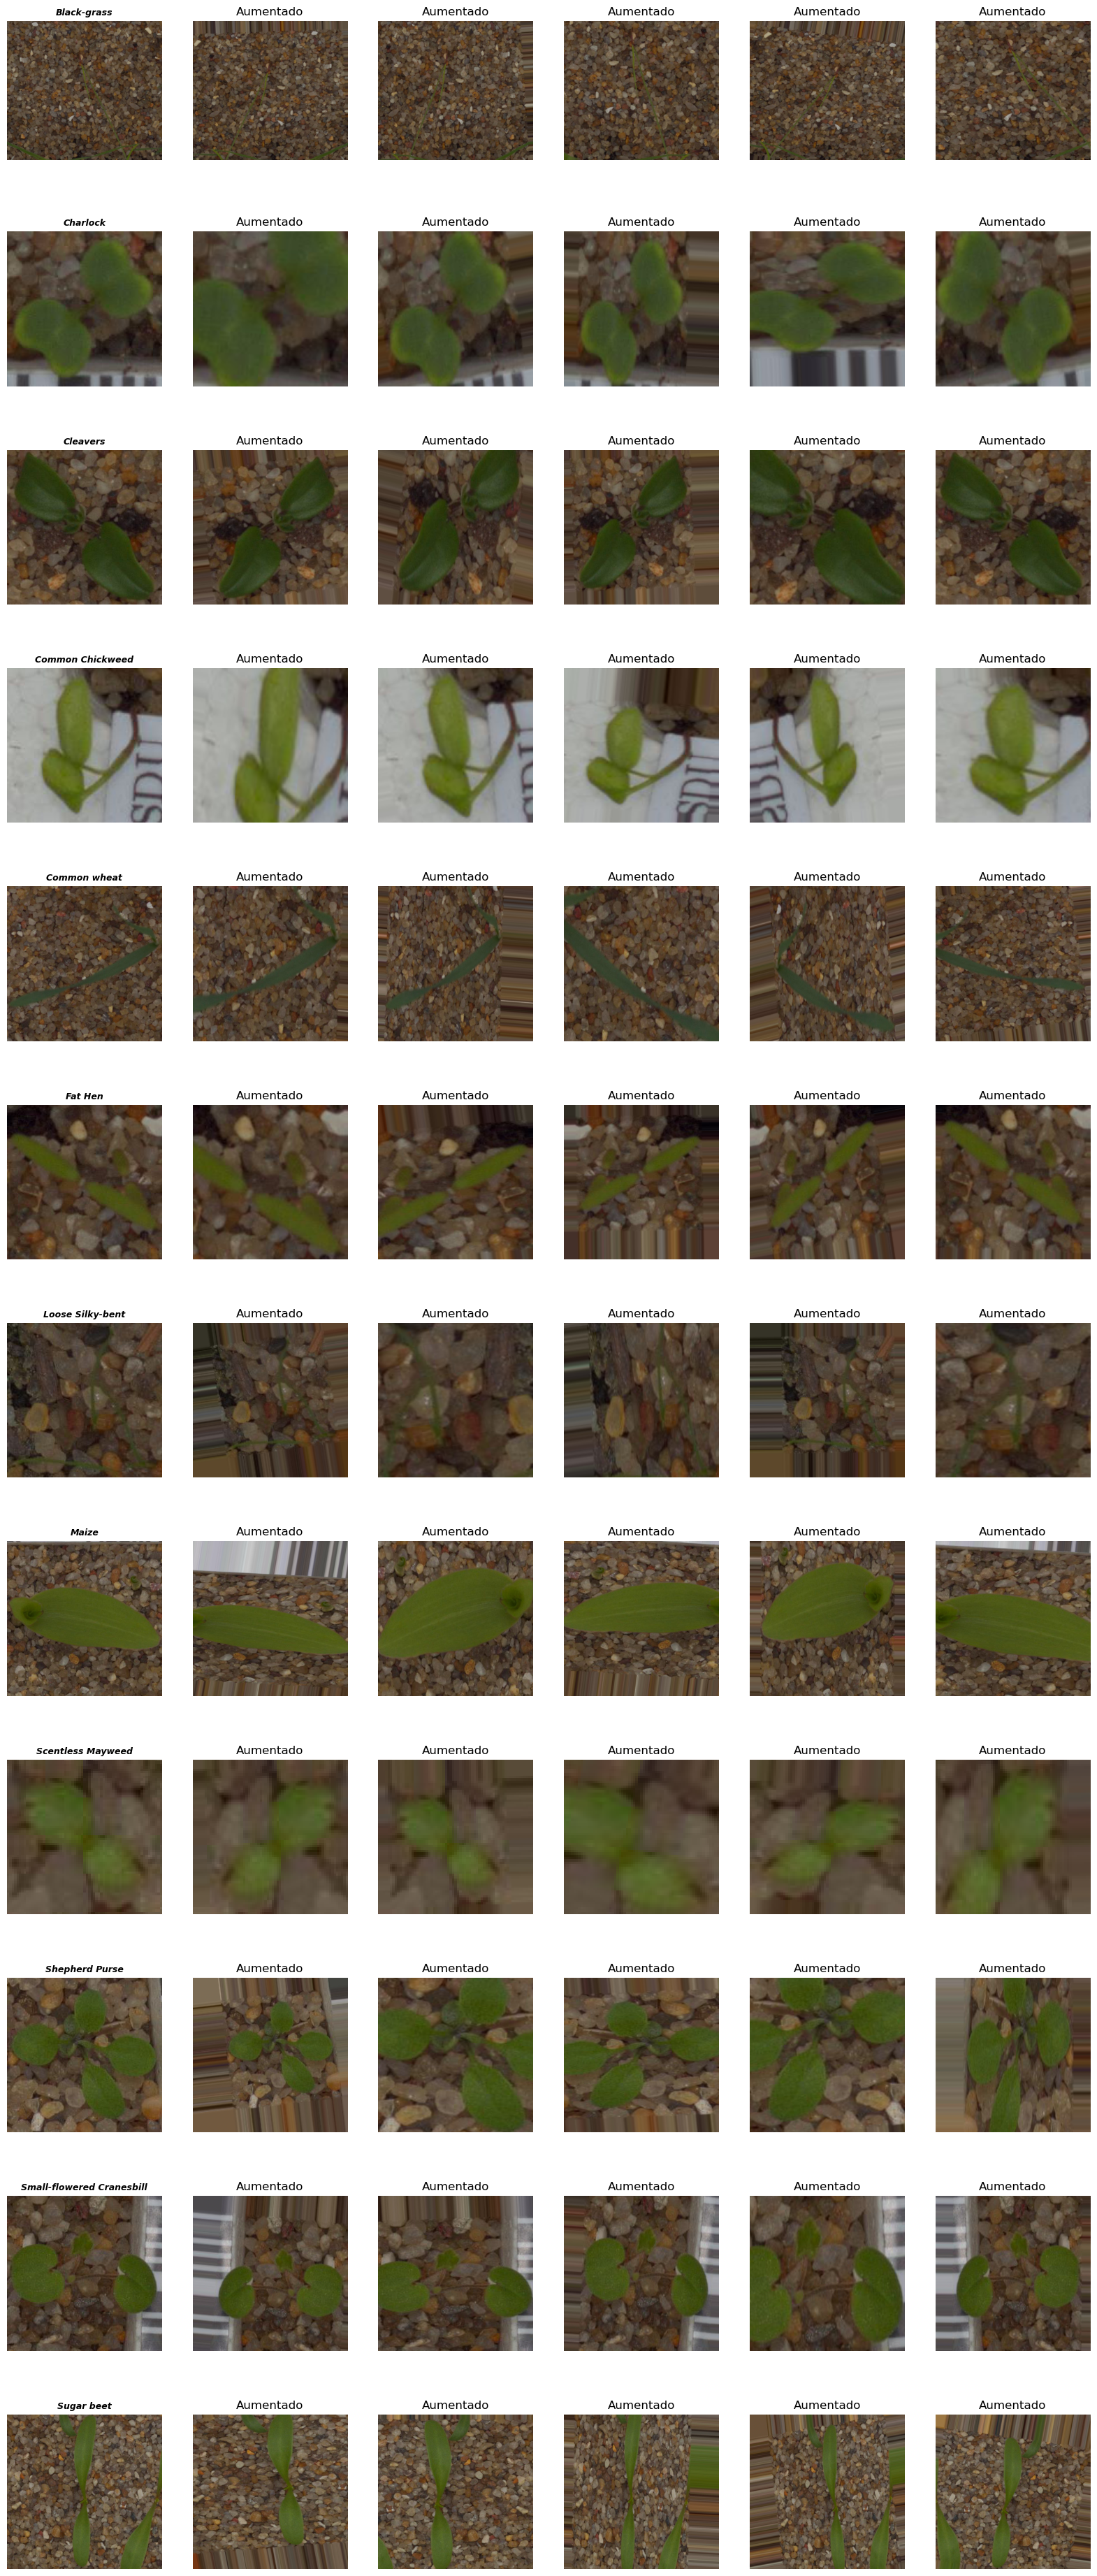

In [69]:
# Visually check data Augmentation

def random_index(x, num_of_samples):
    indices = np.random.choice(num_of_samples, size=x, replace=False)
    return indices

# Visualización de varios resultados de aumentación de datos
fig, ax = plt.subplots(12, 6, figsize=(20, 48))

# Obtener lista de subdirectorios (clases)
class_directories = sorted(os.listdir(train_generator.directory))

i = 0
for directory in class_directories:
    class_path = os.path.join(train_generator.directory, directory)
    num_of_samples = len(os.listdir(class_path))
    indice = random_index(1, num_of_samples)

    image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg') or f.endswith('.png')]
    image_path = os.path.join(class_path, image_files[indice[0]])
    ax[i, 0].imshow(io.imread(image_path))
    ax[i, 0].set_title(directory, fontstyle="italic", fontweight='bold', fontsize=9)
    ax[i, 0].axis("off")

    for j in range (1,6):
        ax[i, j].imshow(train_data_generator.random_transform(io.imread(image_path)))
        ax[i, j].set_title("Aumentado")
        ax[i, j].axis("off")
    i += 1

# Second part: Convolutional Neural Network

In [70]:
inputs = Input(shape = (224, 224, 3), name = "Input")

first_layer = Conv2D(filters = 32,
                     kernel_size = (5, 5),
                     padding = 'valid',
                     activation = 'relu')

second_layer = MaxPooling2D(pool_size = (2, 2))



x=first_layer(inputs)
x=second_layer(x)

In [71]:
third_layer = Dropout(rate = 0.2)

fourth_layer = Flatten()

fifth_layer = Dense(units = 128,
                    activation = 'relu')

output_layer = Dense(units = 12,
                     activation='softmax')

x=third_layer(x)
x=fourth_layer(x)
x=fifth_layer(x)

outputs=output_layer(x)

model = Model(inputs = inputs, outputs = outputs)

In [72]:
# Save model and history
def save_model_and_history(model, history_list, filename_sufix):
    model_filename = f'model_{filename_sufix}.h5'
    history_filename = f'histories_{filename_sufix}.pkl'
    model.save(model_filename)
    with open(history_filename, 'wb') as file:
        pickle.dump(history_list, file)

def train_model(model, lr, epochs, model_par):
  model.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
  history = model.fit_generator(generator        = model_par[0],
                                validation_data  = model_par[1],
                                steps_per_epoch  = model_par[2],
                                validation_steps = model_par[3],
                                epochs           = epochs,
                                )
  return history.history

In [73]:
# Calculate the correct validation_steps
validation_steps = math.ceil(1113 / batch_size)
steps_per_epoch = math.ceil(4426 / batch_size)
history_list = []
model_par = [train_generator, test_generator, steps_per_epoch, validation_steps]

# 20 epochs lr = 0.0001
history_list.append(train_model(model, 0.0001, 20, model_par))

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15744\320429255.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator        = model_par[0],


Epoch 1/20
35/35 [==============================] - 115s 3s/step - loss: 2.5562 - accuracy: 0.1258 - val_loss: 2.3466 - val_accuracy: 0.2049
Epoch 2/20
35/35 [==============================] - 111s 3s/step - loss: 2.3115 - accuracy: 0.1966 - val_loss: 2.2765 - val_accuracy: 0.2201
Epoch 3/20
35/35 [==============================] - 113s 3s/step - loss: 2.2608 - accuracy: 0.2469 - val_loss: 2.2162 - val_accuracy: 0.3127
Epoch 4/20
35/35 [==============================] - 114s 3s/step - loss: 2.2032 - accuracy: 0.2933 - val_loss: 2.1611 - val_accuracy: 0.2965
Epoch 5/20
35/35 [==============================] - 115s 3s/step - loss: 2.1554 - accuracy: 0.3098 - val_loss: 2.1509 - val_accuracy: 0.2821
Epoch 6/20
35/35 [==============================] - 114s 3s/step - loss: 2.1128 - accuracy: 0.3154 - val_loss: 2.0763 - val_accuracy: 0.3504
Epoch 7/20
35/35 [==============================] - 120s 3s/step - loss: 2.0768 - accuracy: 0.3346 - val_loss: 2.0196 - val_accuracy: 0.3522
Epoch 8/20
35

In [75]:
# 15 epochs lr = 0.00005
history_list.append(train_model(model, 0.00005, 15, model_par))
save_model_and_history(model, history_list, "simple_cnn_224x224")

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15744\320429255.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator        = model_par[0],


Epoch 1/15
35/35 [==============================] - 115s 3s/step - loss: 1.5506 - accuracy: 0.4736 - val_loss: 1.4310 - val_accuracy: 0.5013
Epoch 2/15
35/35 [==============================] - 110s 3s/step - loss: 1.5289 - accuracy: 0.4745 - val_loss: 1.4460 - val_accuracy: 0.5337
Epoch 3/15
35/35 [==============================] - 111s 3s/step - loss: 1.5241 - accuracy: 0.4826 - val_loss: 1.4165 - val_accuracy: 0.5337
Epoch 4/15
35/35 [==============================] - 110s 3s/step - loss: 1.5139 - accuracy: 0.4831 - val_loss: 1.4396 - val_accuracy: 0.5238
Epoch 5/15
35/35 [==============================] - 112s 3s/step - loss: 1.5005 - accuracy: 0.4862 - val_loss: 1.4007 - val_accuracy: 0.5310
Epoch 6/15
35/35 [==============================] - 111s 3s/step - loss: 1.5001 - accuracy: 0.4844 - val_loss: 1.3867 - val_accuracy: 0.5337
Epoch 7/15
35/35 [==============================] - 111s 3s/step - loss: 1.4911 - accuracy: 0.4851 - val_loss: 1.3769 - val_accuracy: 0.5247
Epoch 8/15
35

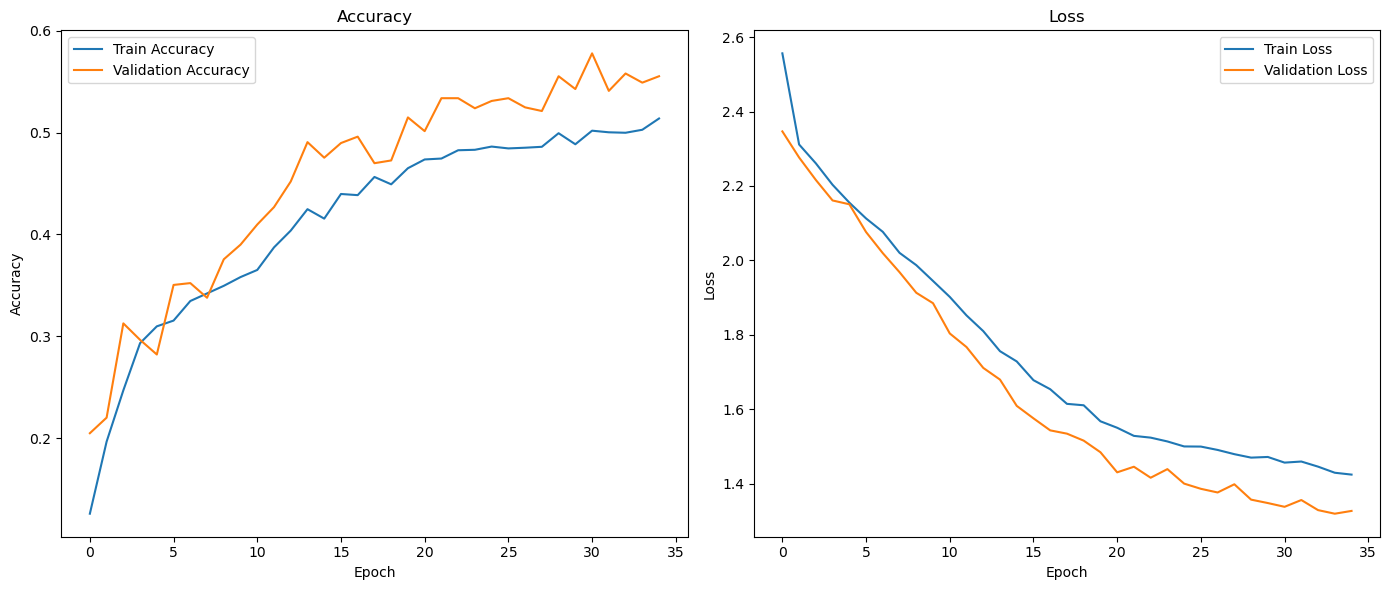

In [76]:
# Crear una figura y ejes para el gráfico
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

history_acc = []
history_val_acc = []
history_loss = []
history_val_loss = []

# Recopilar las precisiones (accuracy) de todas las historias en history_list
for history in history_list:
    history_acc.extend(history['accuracy'])
    history_val_acc.extend(history['val_accuracy'])
    history_loss.extend(history['loss'])
    history_val_loss.extend(history['val_loss'])

# Graficar la precisión (accuracy) en función de las épocas
axes[0].plot(history_acc, label='Train Accuracy')
axes[0].plot(history_val_acc, label='Validation Accuracy')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history_loss, label='Train Loss')
axes[1].plot(history_val_loss, label='Validation Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

plt.tight_layout()
plt.show()

In [79]:
# Volvemos a definir el test_generator con shuffle=False.
# Esto desactiva la mezcla aleatoria de los datos en cada época durante el proceso de evaluación lo cual es útil para asegurarte
# de que las predicciones coincidan con las etiquetas en el orden correcto.
test_generator = test_data_generator.flow_from_directory(directory="../Test_original",
                                                         class_mode ="sparse",
                                                        target_size = (224 , 224),
                                                        batch_size = batch_size,
                                                        shuffle=False)

# Obtener el número total de muestras en el conjunto de prueba
num_samples_test = test_generator.samples
print("num_samples_test", num_samples_test)

# Obtener las etiquetas reales del conjunto de prueba
y_true = test_generator.classes

# Realizar predicciones en el conjunto de prueba
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convertir las predicciones continuas en clases
predicted_classes = np.argmax(predictions, axis=1)

print("length y_true", len(y_true))
print("length predicted_classes", len(predicted_classes))

# Mostrar el classification report
print(classification_report(y_true, predicted_classes))

Found 1113 images belonging to 12 classes.
num_samples_test 1113
9/9 [==============================] - 5s 503ms/step
length y_true 1113
length predicted_classes 1113
              precision    recall  f1-score   support

           0       0.43      0.10      0.16        62
           1       0.49      0.95      0.65        91
           2       0.59      0.36      0.44        67
           3       0.68      0.80      0.74       143
           4       0.50      0.14      0.22        51
           5       0.69      0.31      0.42       108
           6       0.52      0.89      0.66       153
           7       0.91      0.19      0.32        52
           8       0.54      0.58      0.56       122
           9       0.15      0.05      0.08        55
          10       0.61      0.79      0.69       116
          11       0.46      0.39      0.42        93

    accuracy                           0.56      1113
   macro avg       0.55      0.46      0.45      1113
weighted avg       0.

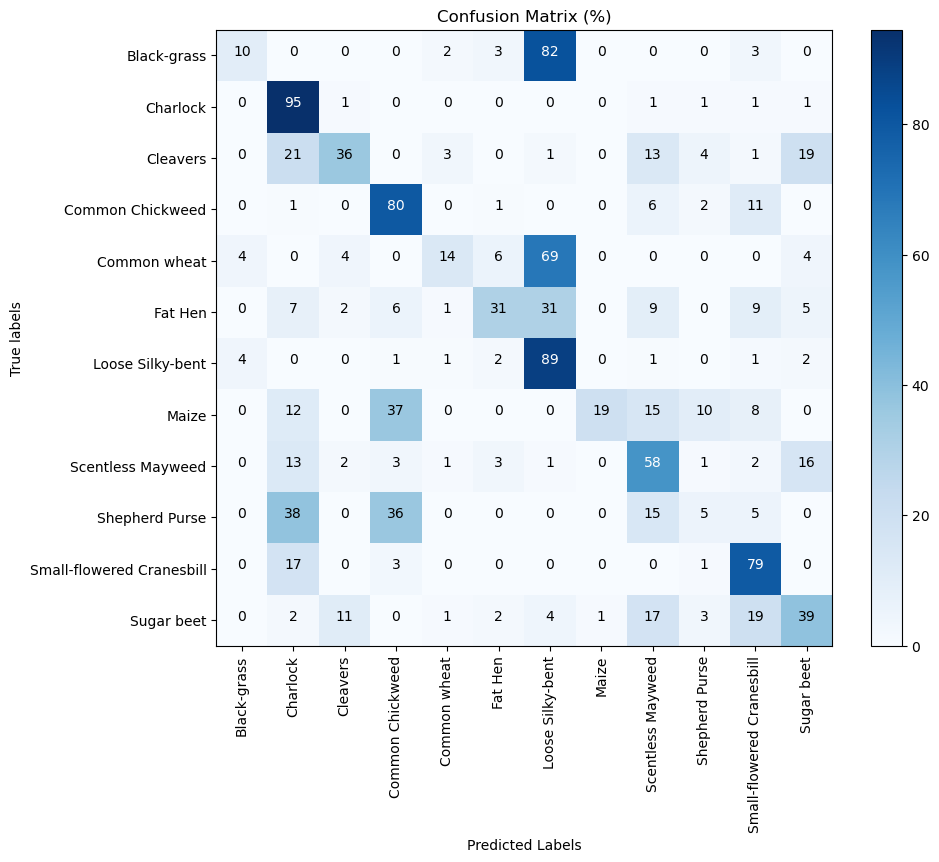

In [82]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true, predicted_classes)

# Normalize the confusion matrix to show percentages
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Get class names from test_generator class indices
class_names = list(test_generator.class_indices.keys())

#plt.figure()
plt.figure(figsize=(10, 8))

plt.imshow(cm_percent, interpolation='nearest', cmap='Blues')
plt.title("Confusion Matrix (%)")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm_percent[i, j]:.0f}",  # Display percentage value
             horizontalalignment="center",
             color="white" if cm_percent[i, j] > (cm_percent.max() / 2) else "black")

plt.ylabel('True labels')
plt.xlabel('Predicted Labels')

plt.show()

## Effect 100x100 ==> 224x224 improvement of 0%